# Description

Initial EDA for potential propensity score matching leakage, now accounting for random effects meta analysis for a given RCT study.

In [20]:
# source: https://stackoverflow.com/a/28073228
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Imports

In [21]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import ipywidgets as widgets
import warnings

from ipywidgets import interact, interact_manual
from statsmodels.stats.meta_analysis import combine_effects

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# user imports

from utils import compute_study_pairs

# Load data

In [23]:
# sheet_name=None loads all sheets as a dict
psm_leak_dict = pd.read_excel("data/psm_leakage.xlsx", sheet_name=None, engine='openpyxl')

In [24]:
meta_studies = list(psm_leak_dict.keys())

psm_leak = pd.DataFrame()
for study, df in psm_leak_dict.items():
    df['meta_study'] = study
    psm_leak = psm_leak.append(df)
    
psm_leak = psm_leak.reset_index()

In [25]:
psm_leak = psm_leak.drop('index', axis='columns')

In [26]:
# restrict to kitsios2015 and hemkens2016 for now
#psm_leak = psm_leak[psm_leak['meta_study'].isin(["kitsios2015", "hemkens2016"])]

In [27]:
# need to drop the old indices as they aren't numbered consecutively
psm_leak = psm_leak.reset_index(drop=True).reset_index()

In [28]:
psm_leak = psm_leak.rename({"index": "study_id"}, axis="columns")
psm_leak['study_id'] = psm_leak['study_id'].astype(str)
psm_leak.head()
psm_leak['ci_diff'] = psm_leak['upper_ci'] - psm_leak['lower_ci']

In [29]:
psm_leak['study_type'].value_counts()

RCT    104
PS      56
Name: study_type, dtype: int64

In [30]:
psm_leak.tail(10)

,study_id,study_type,year,clinical_setting,estimate,lower_ci,upper_ci,meta_study,month,note,area,ci_diff
150,150,PS,2016,Clopidogrel treatment duration 3 month v >3 mo...,0.20,0.00,1.300,hemkens2016,NaT,NaN,NaN,1.300
151,151,RCT,2017,Clopidogrel treatment duration 3 month v >3 mo...,0.91,0.61,1.350,hemkens2016,NaT,NaN,NaN,0.740
152,152,PS,2016,Very early angiography (within 6h) v early con...,0.89,0.69,1.170,hemkens2016,NaT,NaN,NaN,0.480
153,153,RCT,2017,Very early angiography (within 6h) v early con...,0.85,0.40,1.840,hemkens2016,NaT,NaN,NaN,1.440
154,154,PS,2016,Beta blocker continuation v beta blocker withd...,0.42,0.21,0.857,hemkens2016,NaT,NaN,NaN,0.647
155,155,RCT,2017,Beta blocker continuation v beta blocker withd...,0.99,0.34,2.880,hemkens2016,NaT,NaN,NaN,2.540
156,156,PS,2016,Surgical removal of the primary tumor v no sur...,0.64,0.59,0.680,hemkens2016,NaT,NaN,NaN,0.090
157,157,RCT,2017,Surgical removal of the primary tumor v no sur...,0.92,0.56,1.530,hemkens2016,NaT,NaN,NaN,0.970
158,158,PS,2016,"CABG v drug eluting stent, Unprotected, left m...",0.74,0.16,3.420,hemkens2016,NaT,NaN,NaN,3.260
159,159,RCT,2017,"CABG v drug eluting stent, Unprotected, left m...",1.23,0.70,2.170,hemkens2016,NaT,NaN,NaN,1.470


In [31]:
def compute_rr_log_var(estimate, upper_ci):
    """Uses closed form solution to compute sample variance of relative risk"""
    z_95 = scipy.stats.norm.ppf(0.975, 0, 1)
    
    log_se = (np.log(upper_ci) - np.log(estimate)) / z_95
    
    return log_se ** 2

In [139]:
def get_random_eff_est(group_df):
    """Computes random effect rct point estimate of group_df"""
    group_df = group_df.copy()
    #display(group_df.dtypes)
    #display(group_df)
    group_df['rct_log_var'] = group_df.apply(lambda row: compute_rr_log_var(row['rct_est'], row['rct_upper_ci']), axis=1)
    group_df['ps_log_var'] = group_df.apply(lambda row: compute_rr_log_var(row['ps_est'], row['ps_upper_ci']), axis=1)
    
    #display(group_df)
    #display(group_df.shape)
    #print(group_df['rct_est'].dtype)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #display(group_df)
        #print(group_df.shape)
        rct_df = group_df.drop_duplicates(subset=['rct_study_id']).copy()
        #display(rct_df)
        #print(rct_df.shape)
        #print()
        rct_results = combine_effects(np.log(np.array(rct_df['rct_est'].astype(float))), 
                                      rct_df['rct_log_var'])

        rct_est = rct_results.summary_frame().loc['random effect', 'eff']
        rct_sd = rct_results.summary_frame().loc['random effect', 'sd_eff']
        
        
        ps_df = group_df.drop_duplicates(subset=['ps_study_id']).copy()
        ps_results = combine_effects(np.log(np.array(ps_df['ps_est'].astype(float))), 
                                     ps_df['ps_log_var'])

        ps_est = ps_results.summary_frame().loc['random effect', 'eff']
        ps_sd = ps_results.summary_frame().loc['random effect', 'sd_eff']
    
    # need to re-exponentiate to get RRs back
    return pd.DataFrame.from_dict({
        "ps_est": [np.exp(ps_est)],
        "rct_est": [np.exp(rct_est)],
        "ps_var": [np.exp(ps_sd ** 2)],
        "rct_var": [np.exp(rct_sd ** 2)],
    })
    
    

# Clip studies with large CIs

During a live coding session, Konrad and I examined the confidence intervals
and decided to remove studies with large intervals -- the choice of 3 as the cutoff
was arbitrary based on visual inspection and more formal analysis will need a more formal method for outlier
removal (e.g. 2-3 SDs).

In [128]:
psm_leak['ci_diff'].describe()

count    154.000000
mean       1.967123
std        3.335260
min        0.090000
25%        0.492500
50%        0.945000
75%        1.867500
max       31.320000
Name: ci_diff, dtype: float64

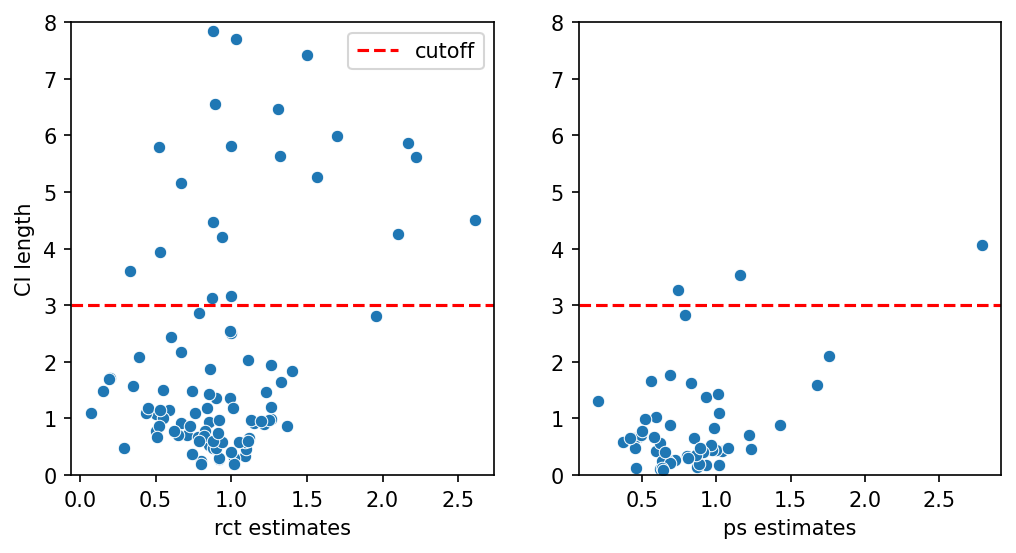

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150, figsize=(8,4))
rct = psm_leak[psm_leak['study_type'] == 'RCT']
ps = psm_leak[psm_leak['study_type'] == 'PS']

sns.scatterplot(data=rct, x='estimate', y='ci_diff', ax=ax1)
ax1.set_ylim(0, 8)
ax1.set_xlabel("rct estimates")
ax1.set_ylabel("CI length")
ax1.axhline(y=3, ls='--', color='red', label='cutoff')
ax1.legend()

sns.scatterplot(data=ps, x='estimate', y='ci_diff', ax=ax2)
ax2.set_ylim(0, 8)
ax2.set_ylabel("")
ax2.axhline(y=3, ls='--', color='red', label='cutoff')
ax2.set_xlabel("ps estimates");
fig.patch.set_facecolor("white")


In [130]:
#sel_psm_leak = psm_leak[psm_leak['ci_diff'] < 3]
sel_psm_leak = psm_leak.copy()

# Compute pairwise differences

For each PS study within a clinical setting, we pair it with an RCT and compute
the year difference between each pair.

**NB**: since this is a one-to-many mapping *per PS study*, there will be 
repeated measurements of both PS and RCT studies. More formal analysis will need
to account for this group structure.

In [131]:
pair_df = compute_study_pairs(sel_psm_leak)

# Relationship between RCT and PS estimates: regression

For the initial analysis, we discard PS-RCT pairs that were published in the same year.

**TODO**: further data collection could take a look at the specific studies cited
and their specific month/day publication date for more granularity.

In [132]:
no_zero_pairs = pair_df[pair_df['year_diff'] != 0].copy()

In [133]:
no_zero_pairs = no_zero_pairs[~no_zero_pairs[['rct_est', 'ps_est']].isna().any(axis=1)]

In [134]:
# indicator function for the PS study coming *after* the RCT
no_zero_pairs['ps_after'] = (no_zero_pairs['year_diff'] > 0).astype(int)

In [170]:
# helper function for regression results
def get_reg_results(data, name, x, y='rct_est', inv_var_weight=False):
    sel_cols = ['names', 'coef', 'se', 'pval', 'CI[2.5%]', 'CI[97.5%]']
    if inv_var_weight:
        weights = 1 / data['rct_var']
        
        # we want the second entry, for the x coefficient results
        reg_results = pg.linear_regression(data[x], data[y], add_intercept=True, remove_na=True, weights=weights).loc[1, sel_cols]
        reg_dict = pg.linear_regression(data[x], data[y], add_intercept=True, remove_na=True, weights=weights, as_dataframe=False)
    else:
        reg_results = pg.linear_regression(data[x], data[y], add_intercept=True, remove_na=True).loc[1, sel_cols]
        reg_dict = pg.linear_regression(data[x], data[y], add_intercept=True, remove_na=True, as_dataframe=False)
    #display(reg_results)
    reg_df = reg_results.to_frame().transpose()
    reg_df.index = [name]
    return reg_df, reg_dict

#get_reg_results(no_zero_pairs[no_zero_pairs['ps_after'] == 0], 'test', x='ps_est')

In [171]:
no_zero_pairs[['rct_ci_diff', 'ps_ci_diff']].max()

rct_ci_diff    31.32
ps_ci_diff      4.06
dtype: float64

In [175]:
group_col = 'ps_study_id'

@interact_manual(
    group_col=['ps_study_id', 'clinical_setting'],
    #group_method=['mean', 'random_effects'],
    ci_diff=widgets.FloatSlider(
        value=3,
        min=1,
        max=33.0,
        step=1,
    ),
    plot_group=[
        'before',
        'after',
        'both'
    ]
#     meta_studies=widgets.SelectMultiple(
#         options=[None] + meta_studies,
#         value=[None],
#     )
)
def show_reg(group_col, #group_method, 
             ci_diff, 
             log_transform=False, 
             inv_var_weight=False,
             se_crosshairs=True,
             show_reg=True,
             plot_group='both'):
    group_method = 'random_effects'
    meta_studies = [None]
    
    fig, ax = plt.subplots(dpi=125, figsize=(10,4))
    
    if None in list(meta_studies):
        sel_pairs = no_zero_pairs.copy()
    else:
        sel_pairs = no_zero_pairs[no_zero_pairs['meta_study'].isin(list(meta_studies))].copy()

    sel_pairs = sel_pairs[(sel_pairs['rct_ci_diff'] < ci_diff) & (sel_pairs['ps_ci_diff'] < ci_diff)]

        
    #grouped = sel_pairs.sort_values(by=[group_col, 'rct_ci_diff'], ascending=True).groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].head()
    
    if group_method == "random_effects":
        grouped = sel_pairs.groupby(['ps_after', group_col])[['ps_study_id', 'rct_study_id', 'rct_est', 'ps_est', 'ps_upper_ci', 'rct_upper_ci']].apply(get_random_eff_est)
        grouped = grouped.reset_index()
    
    elif group_method == 'mean':
        grouped = sel_pairs.groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].mean()

    print("{0} grouped pairs: {1} PS before, {2} PS after".format(grouped.shape[0],
                                                            grouped[grouped['ps_after'] == 0].shape[0], 
                                                            grouped[grouped['ps_after'] == 1].shape[0]))
    
    if log_transform:
        grouped['rct_est'] = np.log(grouped['rct_est'])
        grouped['ps_est'] = np.log(grouped['ps_est'])
        grouped['rct_var'] = np.log(grouped['rct_var'])
        grouped['ps_var'] = np.log(grouped['ps_var'])
    
    if se_crosshairs:
        
        before_xerr = np.sqrt(grouped[grouped['ps_after'] == 0]['ps_var'])
        before_yerr = np.sqrt(grouped[grouped['ps_after'] == 0]['rct_var'])
        after_xerr = np.sqrt(grouped[grouped['ps_after'] == 1]['ps_var'])
        after_yerr = np.sqrt(grouped[grouped['ps_after'] == 1]['rct_var'])

        
        if not log_transform:
            before_xerr = np.exp(before_xerr)
            before_yerr = np.exp(before_yerr)
            after_xerr = np.exp(after_xerr)
            after_yerr = np.exp(after_yerr)
            
        if (plot_group == 'before') or (plot_group == 'both'):
            ax.errorbar(x=grouped[grouped['ps_after'] == 0]['ps_est'],
                        y=grouped[grouped['ps_after'] == 0]['rct_est'],
                        xerr=before_xerr,
                        yerr=before_yerr,
                        ls='none',
                        color='blue',
                        #marker='o',
                        alpha=0.2)
            
            ax.scatter(x=grouped[grouped['ps_after'] == 0]['ps_est'],
                       y=grouped[grouped['ps_after'] == 0]['rct_est'],
                       color='blue',
                       s=0.5 * (1 / before_yerr)
                      )
        if (plot_group == 'after') or (plot_group == 'both'):
            ax.errorbar(x=grouped[grouped['ps_after'] == 1]['ps_est'],
                 y=grouped[grouped['ps_after'] == 1]['rct_est'],
                 xerr=after_xerr,
                 yerr=after_yerr,
                 ls='none',
                 color='orange',
                 #marker='o',
                 alpha=0.2)
            
            ax.scatter(x=grouped[grouped['ps_after'] == 1]['ps_est'],
                       y=grouped[grouped['ps_after'] == 1]['rct_est'],
                       color='orange',
                       s=5.0 * (1 / after_yerr)
                      )
    else:
        sns.scatterplot(data=grouped, x='ps_est', y='rct_est', hue='ps_after', ax=ax)
        
    if show_reg:# and not inv_var_weight:
        if (plot_group == 'before') or (plot_group == 'both'):
            sns.regplot(data=grouped[grouped['ps_after'] == 0], x='ps_est', y='rct_est', color='blue', ax=ax, scatter=False)
        if (plot_group == 'after') or (plot_group == 'both'):
            sns.regplot(data=grouped[grouped['ps_after'] == 1], x='ps_est', y='rct_est', color='orange', ax=ax, scatter=False)
    ax.set_title(f"outlier clipped, grouped by {group_col}, method: {group_method}")
    ax.set_xlabel("PS study effect estimate")
    ax.set_ylabel("RCT study effect estimate")
    
    
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect((x1-x0)/(y1-y0))
    ax.axhline(y=(y1 + y0)/2, ls='--', color='gray')
    ax.plot(np.linspace(x0, x1, 50), np.linspace(y0, y1, 50), ls='--', color='gray')
    
    ax.set_ylim(y0, y1)
    ax.set_xlim(x0, x1)
    
    #ax1.set_box_aspect(1)
    ax.set_box_aspect(1)

    # show regression results
    name_dict = {
        #'individual pairs, before': sel_pairs[sel_pairs['ps_after'] == 0],
        #'individual pairs, after': sel_pairs[sel_pairs['ps_after'] == 1],
        'grouped pairs, before': grouped[grouped['ps_after'] == 0].copy(),
        'grouped pairs, after': grouped[grouped['ps_after'] == 1].copy(),
    }

    reg_df = pd.DataFrame()
    models = {}
    for name, data in name_dict.items():
        df, model = get_reg_results(data, name, x='ps_est', y='rct_est', inv_var_weight=inv_var_weight)
        reg_df = reg_df.append(df)
        models[name] = model
        
    if show_reg and inv_var_weight:
        x0, x1 = ax.get_xlim()
        if (plot_group == 'before') or (plot_group == 'both'):
            model = models['grouped pairs, before']
            X = np.arange(x0, x1, 0.01)
            y = (model['coef'][1] * X) + (model['coef'][0])
            ax.plot(X, y, color="blue", alpha=0.8, ls='--', label="weighted regression, before")
        if (plot_group == 'after') or (plot_group == 'both'):
            model = models['grouped pairs, after']            
            X = np.arange(x0, x1, 0.01)
            y = (model['coef'][1] * X) + (model['coef'][0])
            ax.plot(X, y, color="orange", ls='--', alpha=0.8, label="weighted regression, after")
            #ax.plot(sorted(model['X']), sorted(model['pred']), color="orange")

        ax.legend()
    display(reg_df)

interactive(children=(Dropdown(description='group_col', options=('ps_study_id', 'clinical_setting'), value='ps…

After grouping (averaging within pairs) either by individual PS study or by clinical setting,
we see a significant positive relationship between the RCT effect estimate and the PS effect
estimate if the PS study came after the RCT, while no significant relationship between
the effects if the PS study came before the RCT.

# Random effects sandbox

In [253]:
get_random_eff_est(pair_df.iloc[0, :].to_frame().transpose())

,ps_est,rct_est
0,-0.210721,-0.653926


In [254]:
results = no_zero_pairs.groupby(["ps_after", "study_id"])[['rct_est', 'ps_est', 'ps_upper_ci', 'rct_upper_ci']].apply(get_random_eff_est)
results.reset_index()

,ps_after,study_id,level_2,ps_est,rct_est
0,0,101,0,-0.210721,-0.653926
1,0,103,0,-0.462035,-0.478036
2,0,105,0,-0.653926,0.058269
3,0,107,0,-0.798508,-0.174353
4,0,109,0,-0.693147,-0.597837
5,0,111,0,-1.609438,-0.094311
6,0,113,0,-0.116534,-0.162519
7,0,115,0,-0.867501,-0.010050
8,0,117,0,-0.446287,-0.083382
9,0,119,0,-0.301105,0.207014


In [223]:
compute_rr_log_var(0.52, 5.85)

1.5249888523152892

In [96]:
(1.91 - 0.62) / z_95

0.6581753594328036

In [97]:
(0.62 - 0.2) / z_95

0.21428965190835467

In [100]:
compute_rr_log_var(0.95, 1.46)

0.04807226878073125

In [111]:
res = combine_effects(np.array([np.log(0.62), np.log(0.95)]), 
                      np.array([.329, .0481]),
                      )
display(res.summary_frame())
res.summary_frame().loc['random effect', 'eff']

,eff,sd_eff,ci_low,ci_upp,w_fe,w_re
0,-0.478036,0.573585,-1.602242,0.646171,0.127552,0.127552
1,-0.051293,0.219317,-0.481147,0.378560,0.872448,0.872448
fixed effect,-0.105725,0.204853,-0.507230,0.295779,1.000000,NaN
random effect,-0.105725,0.204853,-0.507230,0.295779,NaN,1.000000
fixed effect wls,-0.105725,0.142357,-0.384741,0.173290,1.000000,NaN
random effect wls,-0.105725,0.142357,-0.384741,0.173290,NaN,1.000000


-0.10572531391901997

In [115]:
-0.1057 - 0.2048 * 1.96

-0.507108

In [110]:
res = combine_effects(np.array([np.log(0.62), np.log(0.62), np.log(0.62)]), 
                      np.array([0.32, 0.32, 0.32]),
                      )

display(res.summary_frame())
res.summary_frame().loc['random effect', 'eff']

,eff,sd_eff,ci_low,ci_upp,w_fe,w_re
0,-0.478036,0.565685,-1.586759,0.630687,0.333333,0.333333
1,-0.478036,0.565685,-1.586759,0.630687,0.333333,0.333333
2,-0.478036,0.565685,-1.586759,0.630687,0.333333,0.333333
fixed effect,-0.478036,0.326599,-1.118157,0.162086,1.000000,NaN
random effect,-0.478036,0.326599,-1.118157,0.162086,NaN,1.000000
fixed effect wls,-0.478036,0.000000,-0.478036,-0.478036,1.000000,NaN
random effect wls,-0.478036,0.000000,-0.478036,-0.478036,NaN,1.000000


-0.4780358009429998

In [7]:
np.exp(res.summary_frame().loc['random effect', 'sd_eff']) ** 2

1.9216751214214762

In [145]:
np.exp(-0.4780)

0.620022196981994

In [110]:
np.exp(-.507230)

0.6021612574654619

In [108]:
np.exp(-0.105725)

0.8996720238667572

In [68]:
import scipy

z_95 = scipy.stats.norm.ppf(0.975, 0, 1)

In [70]:
(np.log(1.44) - np.log(0.85)) / z_95

0.2689651683622103

In [71]:
(np.log(0.85) - np.log(0.50)) / z_95

0.2707336743163131

In [72]:
np.exp(.27)**2

1.7160068621848583

In [73]:
np.exp(.27**2)

1.0756229692394854

In [54]:
0.87 - 0.44

0.43

In [ ]:
0